In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import Pyramid as pyr
import ExperimentalGeometry as exp
import TilePlot as tp
import PlotLikeMatlab as plm # requires 'pip install pyvista pyvistaqt'

from argparse import Namespace
from matplotlib.colors import LogNorm
from scipy.spatial.transform import Rotation
from tqdm import tqdm
try: 
    from pyfftw.interfaces.numpy_fft import fftshift, fftn, ifftn
except: 
    from numpy.fft import fftshift, fftn, ifftn

In [2]:
%matplotlib notebook

In [3]:
plt.style.use( 'aps' )

In [4]:
np.random.seed( 2809 ) # uncomment this to obtain the manuscript images

In [5]:
simbox = [ 128, 128, 128 ] # simulation box size in pixels
geom = exp.ScatteringGeometry( 
    gamma=12.0,  # deg
    delta=32.1,   # deg
    recipSpaceSteps=simbox
)

In [6]:
detframe = geom.detectorFrame
twothetaBragg = np.arccos( detframe[-1,-1] )
print( 'Bragg angle 2θ = %.3f°'%( twothetaBragg * 180. / np.pi ) ) # gold [111]

Bragg angle 2θ = 34.044°


In [7]:
Breal, Brecip = tuple( detframe.T @ this for this in geom.getSamplingBases() ) # transformed to detector frame
detframe = detframe.T @ detframe # transforming detframe to detector frame, trivially an identity  matrix

In [8]:
edge = 400.  # edge size of pyramid in um

mean_step = np.absolute( np.linalg.det( Breal ) )**( 1./3. )
box  = mean_step * max( simbox ) # simulation box size in um

In [9]:
pyramidNodes = edge * 0.5 * np.array( 
    [ 
        [ -1., -1., 0. ], 
        [ 1., -1., 0. ], 
        [ 1., 1., 0. ], 
        [ -1., 1., 0. ], 
        [ 0., 0., 2. ]
    ]
).T
pyramidNodes -= pyramidNodes.mean( axis=1, keepdims=True ).repeat( pyramidNodes.shape[1], axis=1 )
Rrand = np.linalg.svd( np.random.rand( 3, 3 ) )[0] # random rotation matrix
if np.linalg.det( Rrand )< 0.:
    Rrand = Rrand[:,::-1]
pyramidNodes = Rrand @ pyramidNodes # this rotates pyramid arbitrarily in diffractometer mount

In [10]:
y, x, z = np.meshgrid( *[ np.linspace( -box//2., box//2., n ) for n in simbox ] )
# y = np.flip( y, axis=0 )
grid = np.concatenate( tuple( this.reshape( 1, -1 ) for this in [ x, y, z ] ), axis=0 )
orig = np.zeros( ( 3, 1 ) )
pyramid = pyr.getPyramid( 
    pyramidNodes=pyramidNodes, 
    grid=grid, 
    finalShape=simbox, 
    orig=orig
)

<IPython.core.display.Javascript object>


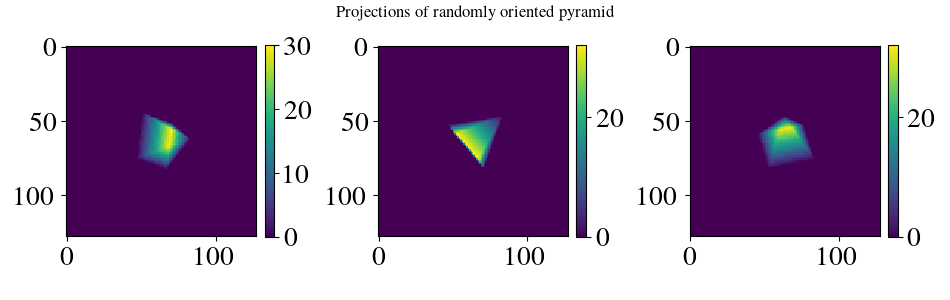

In [11]:
fig, im, ax = tp.TilePlot( tuple( pyramid.sum( axis=n ) for n in [ 0, 1, 2 ] ), ( 1, 3 ), ( 9.5, 3 ) )
plt.suptitle( 'Projections of randomly oriented pyramid' );

In [114]:
# parameters of detector tilt. change each one of these to get different tilts, and different dump files.
xi = 60. * np.pi/180.
zeta = 60. * np.pi/180.
phi = 73. * np.pi/180.
dump_prefix = '60-60-73'

In [115]:
# all symbols come from the manuscript
R1 = Rotation.from_rotvec( xi * ( np.cos( zeta )*detframe[:,0] + np.sin( zeta )*detframe[:,1] ) )
R2 = Rotation.from_rotvec( phi * detframe[:,2] )
Rtilt = ( R2 * R1 ).as_matrix()

P = np.eye( 3 ) - np.outer( detframe[:,2], detframe[:,2] ) # projector into image plane
K = detframe[:,:2].T

S = ( K @ P @ Rtilt @ Brecip[:,:2] ) @ np.linalg.inv( K @ P @ Brecip[:,:2] )

In [116]:
Brecip_new = Brecip.copy()
Brecip_new[:,:2] = P @ Rtilt @ Brecip_new[:,:2] # project sampling steps into image plane

Breal_new = np.linalg.inv( Brecip_new.T ) @ np.diag( 1. / np.array( simbox ) )

In [117]:
grid_new = grid.copy()
# grid_new[:2,:] = np.linalg.inv( S.T ) @ grid_new[:2,:] 
grid_new[:2,:] = np.linalg.inv( S.T ) @ grid_new[:2,:]
pyramid_resampled = pyr.getPyramid( 
    pyramidNodes=pyramidNodes, 
    grid=grid_new, 
    finalShape=simbox, 
    orig=orig
)

q3_new = Brecip[:,-1].copy().reshape( -1, 1 )
q3_new[:2,:] = np.linalg.inv( S ) @ q3_new[:2,:]

diffracted_wave = np.zeros( pyramid.shape ).astype( complex )
offset = simbox[-1] // 2
phase = ( -2. * np.pi * q3_new.T @ grid ).reshape( pyramid_resampled.shape )

In [118]:
for n in tqdm( list( range( simbox[-1] ) ) ):
    diffracted_wave[:,:,n] = fftshift( 
        fftn( 
            fftshift( 
                ( np.exp( 1.j * ( n-offset ) * phase ) * pyramid_resampled ).sum( axis=2 )
            )
        )
    )

diffracted_intensity = np.absolute( diffracted_wave )**2

100%|██████████| 128/128 [00:10<00:00, 12.29it/s]


In [119]:
obj = fftshift( ifftn( fftshift( diffracted_wave ) ) ) # i.e. phase retrieval solution

In [120]:
# plt.figure()
# plt.imshow( diffracted_intensity[:,:,64], norm=LogNorm() )
# plt.colorbar()
# plt.savefig( '../indivFigures/detector_%s.pdf'%dump_prefix )
# plt.title( 'Normal detector' )

<IPython.core.display.Javascript object>


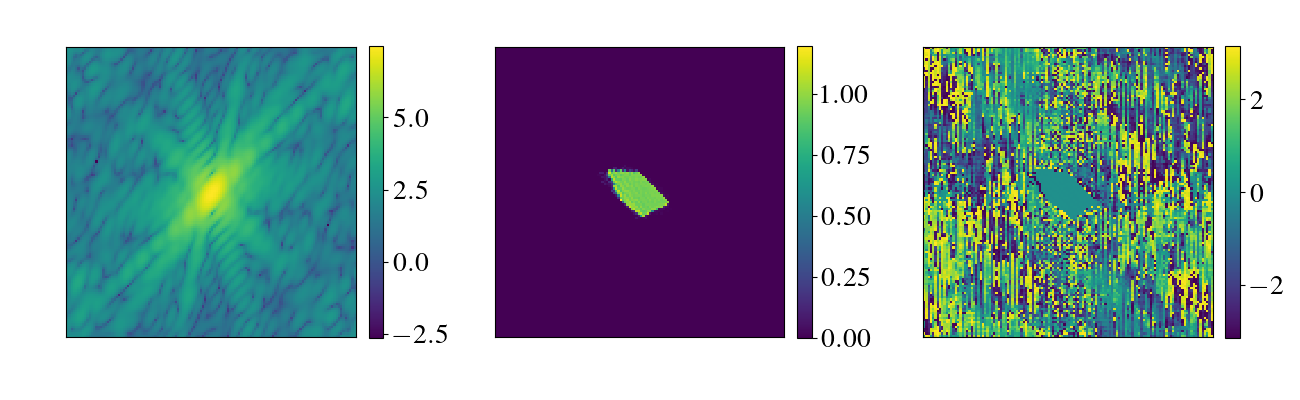

In [121]:
tpl = ( 
    np.log10( diffracted_intensity[:,:,64] ), 
    np.absolute( obj[:,:,64] ), 
    np.angle( obj[:,:,64] )
)
fig, im, ax = tp.TilePlot( tpl, ( 1, 3 ), ( 13, 4 ) )
for this in ax:
    this.set_xticks( [] )
    this.set_yticks( [] )
plt.savefig( '../indivFigures/solution_%s.pdf'%dump_prefix )

In [122]:
# iso_orig = plm.isosurface( 
#     data=pyramid.astype( complex ), 
#     isoval=0.98, 
#     Br = mean_step*np.eye( 3 ), 
#     cmap='cool'
# )

In [123]:
# plm.savefig3d( iso_orig, '../indivFigures/isosurface_%s'%dump_prefix )

In [124]:
iso_h_false = plm.isosurface( 
    data=np.absolute( obj ).astype( complex ), 
    isoval=0.9, 
    Br=Breal, 
    cmap='cool'
)

In [128]:
plm.savefig3d( iso_h_false, '../indivFigures/isosurface_FALSE_%s'%dump_prefix )

In [126]:
iso_h_true = plm.isosurface( 
    data=np.absolute( obj ).astype( complex ), 
    isoval=0.9, 
    Br=Breal_new, 
    cmap='cool'
)

In [129]:
plm.savefig3d( iso_h_true, '../indivFigures/isosurface_TRUE_%s'%dump_prefix )

In [132]:
temp = plm.isosurface( 
    data=np.absolute( obj ).astype( complex ), 
    isoval=0.9999, 
    Br=Breal_new, 
    cmap='cool'
)

In [133]:
plm.savefig3d( temp, '../indivFigures/axes' )